In [1]:
import math

import numpy as np
import pandas as pd
from multiprocessing import process,queues
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('train.data',names=[i for i in range(41)])
m,n=df.shape#m=7k,n=14
X=df.iloc[:,:40]
y=df.iloc[:,[40]]
#index是样本编号

In [3]:
class DevisionTree(object):
    def __init__(self):
        self.lchild=None
        self.rchild=None
        self.div_column=None
        self.div_value=None
        self.is_leaf=False
        self.leaf_value=None
        #二叉树结构，


In [4]:
def loss(y1,y2):
    y11 =np.transpose( np.array(y1))[0]
    y22 =np.transpose( np.array(y2))[0]
    return np.dot(y11-y22,y11-y22)
def gradient(y1,y2):
    y11 = np.array(y1)
    y22 = np.array(y2)
    return -2*sum(y11-y22)[0]
def Henie(y1,y2):
    return len(y1)*2
def _object(y1,y2,lambda_,gama_):
    return -1/2*(gradient(y1,y2)**2)/(Henie(y1,y2)+lambda_)+gama_
def calc_w(y1,y2,lambda_):
    return -gradient(y1,y2)**2/(Henie(y1,y2)+lambda_)

In [5]:

#从上次的训练结果result和训练集的样本y得到新的决策树
def regress_one_tree(min_width,max_depth,train_data,train_res,results,lambda_,gamma_,depth,tree_node):#results 是上次的结果（yt-1） train_res是原始的
    if len(results)<min_width or depth>=max_depth:
        tree_node.is_leaf=True
        #print(train_res)
        tree_node.leaf_value= sum(np.array(train_res-results)) /len(train_res)
        #tree_node.leaf_value=calc_w(train_res,results,lambda_)
        return
    max_obj=-float('inf')
    best_column=-1
    best_value=None
    for col in train_data.columns:
        val=np.transpose(np.array(train_data.loc[:,col].drop_duplicates()))
        #print(val)
        max_val=max(val)
        for v in val:
            #print(v)
            if v==max_val:
                continue

            y_left=train_res.loc[train_data[train_data[col] <= v].index, :]
            y_right=train_res.loc[train_data[train_data[col] > v].index, :]
            res_left=results.loc[train_data[train_data[col] <= v].index, :]
            res_right=results.loc[train_data[train_data[col] > v].index, :]
            o_now=_object(train_res,results,lambda_,gamma_)
            o_left=_object(y_left,res_left,lambda_,gamma_)
            o_right=_object(y_right,res_right,lambda_,gamma_)
            #print(o_now)
            #print(o_now-o_right-o_left)
            if o_now-o_right-o_left>max_obj:
                max_obj=o_now-o_right-o_left
                best_column=col
                best_value=v
    #print(max_obj)
        # if max_obj<=0:
        #     tree_node.is_leaf=True
        #     tree_node.leaf_value= sum(np.transpose(np.array(results)).tolist()[0]) /len(results.index)
        #     return
    tree_node.is_leaf=False
    tree_node.div_column=best_column
    tree_node.div_value=best_value
    tree_node.lchild=DevisionTree()
    tree_node.rchild=DevisionTree()
    y_left=train_res.loc[train_data[train_data[best_column]<=best_value].index,:]
    y_right=train_res.loc[train_data[train_data[best_column]>best_value].index,:]
    res_left=results.loc[train_data[train_data[best_column]<=best_value].index,:]
    res_right=results.loc[train_data[train_data[best_column]>best_value].index,:]


    x_left=train_data.loc[train_data[train_data[best_column]<=best_value].index,:].drop(best_column,axis=1)
    x_right=train_data.loc[train_data[train_data[best_column]>best_value].index,:].drop(best_column,axis=1)
    regress_one_tree(min_width,max_depth,x_left,y_left,res_left,lambda_,gamma_,depth+1,tree_node.lchild)
    regress_one_tree(min_width,max_depth,x_right,y_right,res_right,lambda_,gamma_,depth+1,tree_node.rchild)

In [23]:
#     class DevisionTree(object):
#     def __init__(self):
#         self.lchild=None
#         self.rchild=None
#         self.div_column=None
#         self.div_value=None
#         self.is_leaf=False
#         self.leaf_value=None
#predict one tree
def predict_one_example(tree,x):
    if tree.is_leaf:
        return tree.leaf_value
    col=tree.div_column
    value=tree.div_value
    #print(x[col],value)
    if x[col]>value:
        return predict_one_example(tree.rchild,x)
    else :
        return predict_one_example(tree.lchild,x)
def predict(tree,XX):
    #print(XX.index)
    res=pd.DataFrame([0]*len(XX.index),index=XX.index,columns=[40])
    for i in XX.index:#给每行（每个样本）做预测
        x=XX.loc[i,:]
        res.loc[i,40]=predict_one_example(tree=tree,x=x)
    return res

# def predict_result(tree, feature):
#     if tree.is_leaf:
#         return tree.leaf_value
#     else:
#         if feature[tree.div_column] <= tree.div_value:
#             return predict_result(tree.lchild, feature)
#         else:
#             return predict_result(tree.rchild, feature)
# def predict(tree, features):
#     result_data = pd.DataFrame([0] * len(features.index), index = features.index)
#     print(features,result_data)
#     for x in range(len(features.index)):
#         result_data.iloc[x, 0] = predict_result(tree, features.iloc[x, :])
#     return result_data


In [24]:
tre=DevisionTree()
tre.is_leaf=True
tre.leaf_value=2
result_data = pd.DataFrame([0] * len(X.index), index = X.index,columns=[0])
print(X,result_data)
for a in range(len(X.index)):
    result_data.loc[a, 0] =predict_one_example(tre, X.loc[a, :])
print(result_data)

       0   1     2     3     4    5   6   7      8    9   ...   30   31  \
0       2 -56 -0.33 -0.09  0.90  0.2 -11  12  0.004 -0.1  ...  0.0  0.0   
1     470 -39  0.02  0.12  0.39 -0.6 -12   8  0.009 -1.6  ...  0.0  0.0   
2     165   4  0.14  0.14  0.78  0.4 -11  -9 -0.003 -0.2  ...  0.0  0.0   
3    -113   5 -0.12  0.11  1.06  0.6 -10  -7 -0.008  0.0  ...  0.0  0.0   
4    -411 -21 -0.17  0.07  1.33 -0.6 -11   0  0.002  0.1  ...  0.0  0.0   
...   ...  ..   ...   ...   ...  ...  ..  ..    ...  ...  ...  ...  ...   
7149 -445  -9  0.20 -0.02  0.88 -0.2  -8   7 -0.002 -0.8  ...  0.0  0.0   
7150    9  20 -0.04 -0.03  0.47 -0.6  -9   6  0.002  0.0  ...  0.0  0.0   
7151   50  23  0.14  0.02  0.45 -0.5  -8   1  0.005 -0.1  ...  0.0  0.0   
7152   53  23  0.17  0.02  0.45 -0.4  -8   1  0.005 -0.1  ...  0.0  0.0   
7153  -84  23 -0.13  0.04  0.58  0.2  -8  -3 -0.005  0.0  ...  0.0  0.0   

         32   33   34   35     36   37   38     39  
0     0.000  0.0  0.0  0.0  0.000  0.0  0.9  0

In [25]:
#test
# root=DevisionTree()
# #
# regress_one_tree(min_width=10,max_depth=3,train_data=X,train_res=y,results=y-y,lambda_=1e-3,gamma_=1e-6,depth=0,tree_node=root)
#print(type(root))
# pre=predict(root,X)
# a=loss(pre,y)
# print(a)
#现在每个单元的决策树已经就建立完毕，现在建立xgbt的加法

In [26]:
class xg():
    def __init__(self,X,y,lambda_=0.1,gamma_=0.000001,depth=5, least_width = 70,iter_=5):
        self.J=[]
        self.roots=[]
        self.gamma_=gamma_
        self.lambda_=lambda_
        self.trees=[]
        self.X=X
        self.y=y
        self.lr=1
        self.iter=iter_
        self.miniwidth=least_width
        self.max_depth=depth
        self.res=pd.DataFrame([0] * len(X.index), index = X.index,columns=[40])
    def update_RES(self,tree):
        pre=predict(tree,self.X)
        self.res+=self.lr*pre
        self.trees.append(tree)
        self.J.append(loss(self.res,self.y))
    def train_a_model(self):
        self.trees=[]
        for i in range(int (self.iter)):
            new_tree=DevisionTree()
        #regress_one_tree(min_width,max_depth,train_data,train_res,results,lambda_,gamma_,depth,tree_node)\n",
            regress_one_tree(min_width=self.miniwidth,max_depth=self.max_depth,train_data=self.X,train_res=self.y,results=self.res,lambda_=self.lambda_,gamma_=self.gamma_,depth=0,tree_node=new_tree)
            self.update_RES(new_tree)
         #print(self.X,self.y,self.res)\n",
    # def __init__(self,X,y,lambda_=0.1,gamma_=0.000001,depth=4, least_width = 70,iter_=4):
    #     self.J=[]
    #     self.roots=[]
    #     self.gamma_=gamma_
    #     self.lambda_=lambda_
    #     self.trees=[]
    #     self.y=y
    #     self.X=X
    #     self.lr=1
    #     self.iter=iter_
    #     self.miniwidth=least_width
    #     self.max_depth=depth
    #     self.res= pd.DataFrame({"regressions": [0] * len(self.X.index)},index = self.X.index, columns = ["regressions"])
    # def update_RES(self,tree):
    #     pre=predict(tree,self.X)
    #     self.res+=self.lr*pre
    #     self.trees.append(tree)
    #     self.J.append(loss(self.res,self.y))
    #     return
    # def train_a_model(self):
    #     self.trees=[]
    #     for i in range(int (self.iter)):
    #         new_tree=DevisionTree()
    #         #regress_one_tree(min_width,max_depth,train_data,train_res,results,lambda_,gamma_,depth,tree_node)
    #         regress_one_tree(min_width=self.miniwidth,max_depth=self.max_depth,train_data=self.X,train_res=self.y,results=self.res,lambda_=self.lambda_,gamma_=self.gamma_,depth=0,tree_node=new_tree)
    #         self.update_RES(new_tree)
    #         #print(self.X,self.y,self.res)
    # def run_XGBoost(self,features):
    #     do_feature = features
    #     do_result = pd.DataFrame({"results": [0] * len(features.index)}, index =features.index, columns = ["regressions"])
    #     regression_data = pd.DataFrame({"regressions": [0] * len(features.index)},index = features.index, columns = ["regressions"])
    #     for t_root in self.trees:
    #         new_result = predict(t_root, do_feature)
    #     do_result, regression_data = self.update_RES(do_result,regression_data, new_result)

# moxing=xg(X,y)
# moxing.train_a_model()
# a=np.linspace(0,len(moxing.J)-1,endpoint=True,num=len(moxing.J))
# plt.plot(a,moxing.J)

In [27]:
print(X,type(y))
row_data=df.sample(frac=1)#打乱
x1=row_data.iloc[:(7154-715),:]
x2=row_data.iloc[(7154-715):,:]
y1=x1.loc[:,40]
y2=x2.iloc[:,40]
x1=x1.drop(columns=[40])
x2=x2.drop(columns=[40])
x1=x1.reset_index(drop=True)
x2=x2.reset_index(drop=True)
y1=y1.reset_index(drop=True)
y2=y2.reset_index(drop=True)
y1=pd.DataFrame(y1)
y2=pd.DataFrame(y2)
M=xg(x1,y1)
M.train_a_model()
rres=pd.DataFrame([0] * len(x2.index), index = x2.index,columns=[40])
for tree in M.trees:
    rres=rres+predict(tree,x2)
print(rres,y2)

       0   1     2     3     4    5   6   7      8    9   ...   30   31  \
0       2 -56 -0.33 -0.09  0.90  0.2 -11  12  0.004 -0.1  ...  0.0  0.0   
1     470 -39  0.02  0.12  0.39 -0.6 -12   8  0.009 -1.6  ...  0.0  0.0   
2     165   4  0.14  0.14  0.78  0.4 -11  -9 -0.003 -0.2  ...  0.0  0.0   
3    -113   5 -0.12  0.11  1.06  0.6 -10  -7 -0.008  0.0  ...  0.0  0.0   
4    -411 -21 -0.17  0.07  1.33 -0.6 -11   0  0.002  0.1  ...  0.0  0.0   
...   ...  ..   ...   ...   ...  ...  ..  ..    ...  ...  ...  ...  ...   
7149 -445  -9  0.20 -0.02  0.88 -0.2  -8   7 -0.002 -0.8  ...  0.0  0.0   
7150    9  20 -0.04 -0.03  0.47 -0.6  -9   6  0.002  0.0  ...  0.0  0.0   
7151   50  23  0.14  0.02  0.45 -0.5  -8   1  0.005 -0.1  ...  0.0  0.0   
7152   53  23  0.17  0.02  0.45 -0.4  -8   1  0.005 -0.1  ...  0.0  0.0   
7153  -84  23 -0.13  0.04  0.58  0.2  -8  -3 -0.005  0.0  ...  0.0  0.0   

         32   33   34   35     36   37   38     39  
0     0.000  0.0  0.0  0.0  0.000  0.0  0.9  0

KeyboardInterrupt: 

In [13]:
rres=pd.DataFrame([0] * len(x2.index), index = x2.index,columns=[40])
for tree in M.trees:
    rres=rres+predict(tree,x2)
rres=np.transpose(np.array(rres))[0]
y22=np.transpose(np.array(y2))[0]
ave=np.mean(y22)
print(ave)
RMSE=np.linalg.norm(rres - y22,ord=2) / math.sqrt(len(y22))
R=1-np.linalg.norm(rres-y22,ord=2)**2/np.linalg.norm(y22-ave,ord=2)**2
print(RMSE,R)

RangeIndex(start=0, stop=715, step=1)
RangeIndex(start=0, stop=715, step=1)
RangeIndex(start=0, stop=715, step=1)
RangeIndex(start=0, stop=715, step=1)
RangeIndex(start=0, stop=715, step=1)
-0.000873986013986014
0.0002071240509703186 0.7420120925146423


In [28]:
def t(lambda_=0.1,gamma_=0.000001,depth=5, least_width = 70,iter_=5):
    #print(X, type(y))
    row_data = df.sample(frac=1)  #打乱
    x1 = row_data.iloc[:(7154 - 715), :]
    x2 = row_data.iloc[(7154 - 715):, :]
    y1 = x1.loc[:, 40]
    y2 = x2.iloc[:, 40]
    x1 = x1.drop(columns=[40])
    x2 = x2.drop(columns=[40])
    x1 = x1.reset_index(drop=True)
    x2 = x2.reset_index(drop=True)
    y1 = y1.reset_index(drop=True)
    y2 = y2.reset_index(drop=True)
    y1 = pd.DataFrame(y1)
    y2 = pd.DataFrame(y2)
    M = xg(x1, y1,lambda_=lambda_,gamma_=gamma_,depth=depth, least_width = least_width,iter_=iter_)
    #print(M.iter)
    M.train_a_model()
    rres=pd.DataFrame([0] * len(x2.index), index = x2.index,columns=[40])
    for tree in M.trees:
        rres=rres+predict(tree,x2)
    rres=np.transpose(np.array(rres))[0]
    y22=np.transpose(np.array(y2))[0]
    ave=np.mean(y22)
    #print(ave)
    RMSE=np.linalg.norm(rres - y22,ord=2) / math.sqrt(len(y22))
    R=1-np.linalg.norm(rres-y22,ord=2)**2/np.linalg.norm(y22-ave,ord=2)**2
    print(RMSE,R)

for g in [3e-8,1e-7,3e-6,3e-5]:
    t(gamma_=g)
    print("gamma=",g)
for l in [0.001,0.003,0.01,0.3]:
    t(lambda_=l)
    print("lambda=",l)
for d in [2,8,12,16]:
    t(depth=d)
    print("depth=",d)

for i in [2,8,12,16]:
    t(iter_=i)
    print("iter=",i)


0.0001862443284525286 0.7758445321161277
gamma= 3e-08
0.00021201053114827467 0.7593584059791325
gamma= 1e-07
0.0002137353631027598 0.7538597847950195
gamma= 3e-06
0.00021400747901045473 0.7502384513575996
gamma= 3e-05
0.0001978130742269341 0.773439452682136
lambda= 0.001
0.0001964262481324829 0.7673521915168998
lambda= 0.003
0.00021039869116737503 0.7577091314112543
lambda= 0.01
0.00020090963570989945 0.7400504543086542
lambda= 0.3
0.00021852545754406686 0.7272074965614317
depth= 2
0.0002173352328801674 0.696967706235973
depth= 8
0.0002241941078890356 0.6911105105539258
depth= 12
0.00025556373944664453 0.6143385647275147
depth= 16
0.00021547289740691056 0.7309767773754523
iter= 2
0.00019533965065446422 0.7830636883694284
iter= 8
0.00020496130216064644 0.7232513654191343
iter= 12
0.00019988307788696398 0.7646338551586132
iter= 16


In [29]:
t(gamma_=0)
print("gamma=",0)

0.00021140818060764476 0.7438290061092983
gamma= 0


In [30]:
t()

0.00018791202881863537 0.8018208404593465


      40
2818   0
5552   0
79     0
3283   0
1200   0
...   ..
4959   0
416    0
2713   0
3733   0
5161   0

[715 rows x 1 columns]
                                                     40
2818  [[[[array([-0.0006307988102419404], dtype=obje...
5552  [[[[array([-0.0005246713103912815], dtype=obje...
79    [[[[array([-0.0008543515182232148], dtype=obje...
3283  [[[[array([-0.0012016378658314976], dtype=obje...
1200  [[[[array([-0.0007611344274167465], dtype=obje...
...                                                 ...
4959  [[[[array([-0.0006001830982236793], dtype=obje...
416   [[[[array([-0.0008311893299758134], dtype=obje...
2713  [[[[array([-0.0005921843867588517], dtype=obje...
3733  [[[[array([-0.0004982068079045716], dtype=obje...
5161  [[[[array([-0.00035854324328442474], dtype=obj...

[715 rows x 1 columns]
          40
2818 -0.0005
5552 -0.0006
79   -0.0008
3283 -0.0010
1200 -0.0009
...      ...
4959 -0.0006
416  -0.0008
2713 -0.0006
3733 -0.0006
5161 -0.0004

[715 rows x 1 c

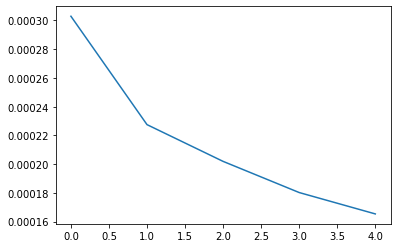

In [12]:

def split_data(row_data):
    #print(row_data)
    row_data=row_data.sample(frac=1)#打乱
    #print(row_data)
    m,n=row_data.shape
    a=int(0.1*m)
    Z=[]
    for i in range(10):
        Z.append(row_data.iloc[a*i:a*(i+1),:])
    return Z
#z0到9就是十折的组分
def check_algorithm(df0):
    R=[]
    RMES=[]
    for i in range(5):
        S=split_data(df0)
        for j in range(10):
            X1=pd.DataFrame(columns=df0.columns)
            #print(X1)
            for k in range(10):
                if k!=j:
                    X1=pd.concat([X1,S[k]],axis=0)
                    #print(X1)
            X2=S[j]
            #print(X1,X2)
            y1=X1.loc[:,[40]]
            X1=X1.drop(labels=[40],axis=1)
            y2=X2.loc[:,[40]]
            X2=X2.drop(labels=[40],axis=1)
            #print(X1.shape,y1.shape,X2.shape,y2.shape)
            moxin=xg(X1,y1)
            moxin.train_a_model()
            a=np.linspace(0,len(moxin.J)-1,endpoint=True,num=len(moxin.J))
            plt.plot(a,moxin.J)
            rres=pd.DataFrame([0] * len(X2.index), index = X2.index,columns=[40])
            print(rres)
            for tree in moxin.trees:
                rres=rres+predict(tree,X2)
            r1=math.sqrt(loss(y2,rres)/len(y2))
            ave=np.mean(np.array(rres))
            AVE=pd.DataFrame([ave] * len(X2.index), index = X2.index,columns=[40])
            r2=1-loss(y2,rres)/loss(AVE,rres)
            print(rres)
            print(y2)
            print(r1,r2)
            R.append(r2)
            RMES.append(r1)
    return R,RMES
            #X1训练集，X2测试集
R,RMSE=check_algorithm(df)
#print("r^2",sum(RR)/len(RR),"RMSE",sum(RMSE)/le0n(RMSE))

In [13]:
print(sum(R)/len(R),sum(RMSE)/len(RMSE))

[array([array([array([array([0.7159174302444853], dtype=object)], dtype=object)],
              dtype=object)                                                      ],
       dtype=object)                                                               ] 0.00021143521810002485
